In [36]:
# def get_data(train_size=0.8):
    
#     split_index = int(train_size*len(data))

#     X = data.drop(columns=['label'])
#     y = data['label']
    
#     x_train, y_train = X[:split_index], y[:split_index]
#     x_test, y_test = X[split_index:], y[split_index:]
    
#     return x_train, y_train, x_test, y_test
# x_train, y_train, x_test, y_test = get_data()

# get_feature(np.array(data['ch4']),3,'mav1')
# X = X.diff().fillna(0)

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns



import sys
sys.path.append('./py_files/feature_creator.py')
sys.path.append('./py_files/featuring_functions.py')

from feature_creator import get_feature, add_feature

In [38]:
data = pd.read_csv('../data/train_file.csv')
# data = data.drop(columns='timestamp_milllisecs')

In [39]:
data.timestamp_milllisecs.diff().describe()

count    7248.000000
mean       72.132036
std        10.308935
min         0.000000
25%        68.000000
50%        70.000000
75%        74.000000
max       122.000000
Name: timestamp_milllisecs, dtype: float64

In [52]:
train_size=0.8
split_index = int(train_size*len(data))
X = data.drop(columns=['label'])
y = data['label']

def get_diff(data, periods=1):
    data_diff = data.diff(periods=periods).fillna(0)
    data_diff.columns = [f'{i}_diff_{periods}' for i in data.columns]
    return data_diff

def add_features_data(data, data_feature, ws=5):
    for new_feature in ['iemg', 'mav', 'mav1', 'mav2', 'ssi']:
        new_feature_name = f'{data_feature}_{new_feature}_{ws}'
        new_feature_array = get_feature(
            data[data_feature], ws, new_feature
        )
        data[new_feature_name] = new_feature_array
    return data

def split_data(X, y):
    x_train, y_train = X[:split_index], y[:split_index]
    x_test, y_test = X[split_index:], y[split_index:]
    return x_train, y_train, x_test, y_test 

def feature_engineering(data):
    data_new = pd.concat([data, get_diff(data), get_diff(data, periods=2)], axis=1)
    data_new = add_features_data(data_new, 'ch6_diff_1')
    return data_new

x_train, y_train, x_test, y_test = split_data(X,y)
x_train_new = feature_engineering(x_train)
x_test_new = feature_engineering(x_test)

# X.shape
counts = np.unique(y_train, return_counts=True)
class_weights = [int(max(counts[1])/i) for i in counts[1]]
weight_dict = dict(zip(counts[0], class_weights))
sample_weight = [weight_dict[i] for i in y_train]

In [53]:
x_train_new.columns

Index(['timestamp_milllisecs', 'ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7',
       'ch8', 'ch9', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch16',
       'timestamp_milllisecs_diff_1', 'ch1_diff_1', 'ch2_diff_1', 'ch3_diff_1',
       'ch4_diff_1', 'ch5_diff_1', 'ch6_diff_1', 'ch7_diff_1', 'ch8_diff_1',
       'ch9_diff_1', 'ch10_diff_1', 'ch11_diff_1', 'ch12_diff_1',
       'ch13_diff_1', 'ch14_diff_1', 'ch15_diff_1', 'ch16_diff_1',
       'timestamp_milllisecs_diff_2', 'ch1_diff_2', 'ch2_diff_2', 'ch3_diff_2',
       'ch4_diff_2', 'ch5_diff_2', 'ch6_diff_2', 'ch7_diff_2', 'ch8_diff_2',
       'ch9_diff_2', 'ch10_diff_2', 'ch11_diff_2', 'ch12_diff_2',
       'ch13_diff_2', 'ch14_diff_2', 'ch15_diff_2', 'ch16_diff_2',
       'ch6_diff_1_iemg_5', 'ch6_diff_1_mav_5', 'ch6_diff_1_mav1_5',
       'ch6_diff_1_mav2_5', 'ch6_diff_1_ssi_5'],
      dtype='object')

In [201]:
param_grid = {
    'n_estimators' : [60,70,80,80,90,100,110,120],
    'max_depth' : [1,2,3,4,5,6],
    'learning_rate' : [0.1, 0.2, 0.3, 0.4],
    'silent':[True]
}

grid_model = GridSearchCV(
    estimator = XGBClassifier(),
    cv = 5,
    param_grid=param_grid,
    verbose=2
)
grid_model.fit(x_train_new, y_train)

# model = XGBClassifier()
# model.fit(x_train_new, y_train, sample_weight=sample_weight)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] learning_rate=0.1, max_depth=1, n_estimators=60, silent=True ....
[02:19:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:19:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/aram/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  learning_rate=0.1, max_depth=1, n_estimators=60, silent=True, total=   0.3s
[CV] learning_rate=0.1, max_depth=1, n_estimators=60, silent=True ....
[02:19:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:19:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=1, n_estimators=60, silent=True, total=   0.2s
[CV] learning_rate=0.1, max_depth=1, n_estimators=60

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=1, n_estimators=60, silent=True, total=   0.2s
[CV] learning_rate=0.1, max_depth=1, n_estimators=60, silent=True ....
[02:19:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:19:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=1, n_estimators=60, silent=True, total=   0.2s
[CV] learning_rate=0.1, max_depth=1, n_estimators=60

[CV]  learning_rate=0.1, max_depth=1, n_estimators=80, silent=True, total=   0.5s
[CV] learning_rate=0.1, max_depth=1, n_estimators=80, silent=True ....
[02:19:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:19:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=1, n_estimators=80, silent=True, total=   0.3s
[CV] learning_rate=0.1, max_depth=1, n_estimators=80

[CV]  learning_rate=0.1, max_depth=1, n_estimators=90, silent=True, total=   0.5s
[CV] learning_rate=0.1, max_depth=1, n_estimators=90, silent=True ....
[02:19:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:19:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=1, n_estimators=90, silent=True, total=   0.5s
[CV] learning_rate=0.1, max_depth=1, n_estimators=90

[CV]  learning_rate=0.1, max_depth=1, n_estimators=110, silent=True, total=   0.4s
[CV] learning_rate=0.1, max_depth=1, n_estimators=110, silent=True ...
[02:19:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:19:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=1, n_estimators=110, silent=True, total=   0.4s
[CV] learning_rate=0.1, max_depth=1, n_estimators=

[CV]  learning_rate=0.1, max_depth=2, n_estimators=60, silent=True, total=   0.3s
[CV] learning_rate=0.1, max_depth=2, n_estimators=60, silent=True ....
[02:19:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:19:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=2, n_estimators=60, silent=True, total=   0.3s
[CV] learning_rate=0.1, max_depth=2, n_estimators=60

[CV]  learning_rate=0.1, max_depth=2, n_estimators=80, silent=True, total=   0.5s
[CV] learning_rate=0.1, max_depth=2, n_estimators=80, silent=True ....
[02:19:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:19:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=2, n_estimators=80, silent=True, total=   0.5s
[CV] learning_rate=0.1, max_depth=2, n_estimators=80

[CV]  learning_rate=0.1, max_depth=2, n_estimators=90, silent=True, total=   0.5s
[CV] learning_rate=0.1, max_depth=2, n_estimators=90, silent=True ....
[02:19:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:19:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=2, n_estimators=90, silent=True, total=   0.5s
[CV] learning_rate=0.1, max_depth=2, n_estimators=90

[CV]  learning_rate=0.1, max_depth=2, n_estimators=110, silent=True, total=   0.6s
[CV] learning_rate=0.1, max_depth=2, n_estimators=110, silent=True ...
[02:19:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:19:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=2, n_estimators=110, silent=True, total=   0.6s
[CV] learning_rate=0.1, max_depth=2, n_estimators=

[CV]  learning_rate=0.1, max_depth=3, n_estimators=60, silent=True, total=   0.5s
[CV] learning_rate=0.1, max_depth=3, n_estimators=60, silent=True ....
[02:20:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:20:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=3, n_estimators=60, silent=True, total=   0.5s
[CV] learning_rate=0.1, max_depth=3, n_estimators=60

[CV]  learning_rate=0.1, max_depth=3, n_estimators=80, silent=True, total=   0.7s
[CV] learning_rate=0.1, max_depth=3, n_estimators=80, silent=True ....
[02:20:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:20:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=3, n_estimators=80, silent=True, total=   0.7s
[CV] learning_rate=0.1, max_depth=3, n_estimators=80

[CV]  learning_rate=0.1, max_depth=3, n_estimators=90, silent=True, total=   1.9s
[CV] learning_rate=0.1, max_depth=3, n_estimators=90, silent=True ....
[02:20:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:20:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=3, n_estimators=90, silent=True, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, n_estimators=90

[CV]  learning_rate=0.1, max_depth=3, n_estimators=110, silent=True, total=   0.9s
[CV] learning_rate=0.1, max_depth=3, n_estimators=110, silent=True ...
[02:20:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:20:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=3, n_estimators=110, silent=True, total=   0.9s
[CV] learning_rate=0.1, max_depth=3, n_estimators=

[CV]  learning_rate=0.1, max_depth=4, n_estimators=60, silent=True, total=   0.8s
[CV] learning_rate=0.1, max_depth=4, n_estimators=60, silent=True ....
[02:20:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:20:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=4, n_estimators=60, silent=True, total=   0.8s
[CV] learning_rate=0.1, max_depth=4, n_estimators=60

[CV]  learning_rate=0.1, max_depth=4, n_estimators=80, silent=True, total=   1.0s
[CV] learning_rate=0.1, max_depth=4, n_estimators=80, silent=True ....
[02:20:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:20:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=4, n_estimators=80, silent=True, total=   0.9s
[CV] learning_rate=0.1, max_depth=4, n_estimators=80

[CV]  learning_rate=0.1, max_depth=4, n_estimators=90, silent=True, total=   1.1s
[CV] learning_rate=0.1, max_depth=4, n_estimators=90, silent=True ....
[02:20:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:20:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=4, n_estimators=90, silent=True, total=   1.1s
[CV] learning_rate=0.1, max_depth=4, n_estimators=90

[CV]  learning_rate=0.1, max_depth=4, n_estimators=110, silent=True, total=   1.8s
[CV] learning_rate=0.1, max_depth=4, n_estimators=110, silent=True ...
[02:21:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:21:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=4, n_estimators=110, silent=True, total=   1.6s
[CV] learning_rate=0.1, max_depth=4, n_estimators=

[CV]  learning_rate=0.1, max_depth=5, n_estimators=60, silent=True, total=   1.0s
[CV] learning_rate=0.1, max_depth=5, n_estimators=60, silent=True ....
[02:21:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:21:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=5, n_estimators=60, silent=True, total=   1.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=60

[CV]  learning_rate=0.1, max_depth=5, n_estimators=80, silent=True, total=   1.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=80, silent=True ....
[02:21:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:21:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=5, n_estimators=80, silent=True, total=   1.5s
[CV] learning_rate=0.1, max_depth=5, n_estimators=80

[CV]  learning_rate=0.1, max_depth=5, n_estimators=90, silent=True, total=   1.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=90, silent=True ....
[02:22:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:22:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=5, n_estimators=90, silent=True, total=   1.8s
[CV] learning_rate=0.1, max_depth=5, n_estimators=90

[CV]  learning_rate=0.1, max_depth=5, n_estimators=110, silent=True, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, n_estimators=110, silent=True ...
[02:22:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:22:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=5, n_estimators=110, silent=True, total=   1.6s
[CV] learning_rate=0.1, max_depth=5, n_estimators=

[CV]  learning_rate=0.1, max_depth=6, n_estimators=60, silent=True, total=   1.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=60, silent=True ....
[02:22:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:22:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=6, n_estimators=60, silent=True, total=   1.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=60

[CV]  learning_rate=0.1, max_depth=6, n_estimators=80, silent=True, total=   1.6s
[CV] learning_rate=0.1, max_depth=6, n_estimators=80, silent=True ....
[02:22:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:22:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=6, n_estimators=80, silent=True, total=   1.6s
[CV] learning_rate=0.1, max_depth=6, n_estimators=80

[CV]  learning_rate=0.1, max_depth=6, n_estimators=90, silent=True, total=   2.4s
[CV] learning_rate=0.1, max_depth=6, n_estimators=90, silent=True ....
[02:23:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:23:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=6, n_estimators=90, silent=True, total=   2.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=90

[CV]  learning_rate=0.1, max_depth=6, n_estimators=110, silent=True, total=   2.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=110, silent=True ...
[02:23:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:23:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.1, max_depth=6, n_estimators=110, silent=True, total=   2.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=


[02:24:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=1, n_estimators=60, silent=True, total=   0.2s
[CV] learning_rate=0.2, max_depth=1, n_estimators=60, silent=True ....
[02:24:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:24:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.

[CV]  learning_rate=0.2, max_depth=1, n_estimators=80, silent=True, total=   0.6s
[CV] learning_rate=0.2, max_depth=1, n_estimators=80, silent=True ....
[02:24:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:24:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=1, n_estimators=80, silent=True, total=   0.3s
[CV] learning_rate=0.2, max_depth=1, n_estimators=80

[CV]  learning_rate=0.2, max_depth=1, n_estimators=90, silent=True, total=   0.3s
[CV] learning_rate=0.2, max_depth=1, n_estimators=90, silent=True ....
[02:24:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:24:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=1, n_estimators=90, silent=True, total=   0.3s
[CV] learning_rate=0.2, max_depth=1, n_estimators=10

[CV]  learning_rate=0.2, max_depth=1, n_estimators=110, silent=True, total=   0.3s
[CV] learning_rate=0.2, max_depth=1, n_estimators=110, silent=True ...
[02:24:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:24:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=1, n_estimators=110, silent=True, total=   0.3s
[CV] learning_rate=0.2, max_depth=1, n_estimators=

[CV]  learning_rate=0.2, max_depth=2, n_estimators=60, silent=True, total=   0.4s
[CV] learning_rate=0.2, max_depth=2, n_estimators=60, silent=True ....
[02:24:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:24:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=2, n_estimators=60, silent=True, total=   0.3s
[CV] learning_rate=0.2, max_depth=2, n_estimators=70

[CV]  learning_rate=0.2, max_depth=2, n_estimators=80, silent=True, total=   0.5s
[CV] learning_rate=0.2, max_depth=2, n_estimators=80, silent=True ....
[02:24:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:24:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=2, n_estimators=80, silent=True, total=   0.5s
[CV] learning_rate=0.2, max_depth=2, n_estimators=80

[CV]  learning_rate=0.2, max_depth=2, n_estimators=90, silent=True, total=   0.5s
[CV] learning_rate=0.2, max_depth=2, n_estimators=90, silent=True ....
[02:24:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:24:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=2, n_estimators=90, silent=True, total=   0.5s
[CV] learning_rate=0.2, max_depth=2, n_estimators=10

[CV]  learning_rate=0.2, max_depth=2, n_estimators=110, silent=True, total=   0.6s
[CV] learning_rate=0.2, max_depth=2, n_estimators=110, silent=True ...
[02:24:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:24:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=2, n_estimators=110, silent=True, total=   0.6s
[CV] learning_rate=0.2, max_depth=2, n_estimators=

[CV]  learning_rate=0.2, max_depth=3, n_estimators=60, silent=True, total=   0.5s
[CV] learning_rate=0.2, max_depth=3, n_estimators=60, silent=True ....
[02:24:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:24:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=3, n_estimators=60, silent=True, total=   0.5s
[CV] learning_rate=0.2, max_depth=3, n_estimators=70

[CV]  learning_rate=0.2, max_depth=3, n_estimators=80, silent=True, total=   0.7s
[CV] learning_rate=0.2, max_depth=3, n_estimators=80, silent=True ....
[02:24:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:24:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=3, n_estimators=80, silent=True, total=   0.7s
[CV] learning_rate=0.2, max_depth=3, n_estimators=80

[CV]  learning_rate=0.2, max_depth=3, n_estimators=90, silent=True, total=   0.8s
[CV] learning_rate=0.2, max_depth=3, n_estimators=90, silent=True ....
[02:24:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:24:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=3, n_estimators=90, silent=True, total=   0.7s
[CV] learning_rate=0.2, max_depth=3, n_estimators=10

[CV]  learning_rate=0.2, max_depth=3, n_estimators=110, silent=True, total=   0.9s
[CV] learning_rate=0.2, max_depth=3, n_estimators=110, silent=True ...
[02:24:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:24:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=3, n_estimators=110, silent=True, total=   0.9s
[CV] learning_rate=0.2, max_depth=3, n_estimators=

[CV]  learning_rate=0.2, max_depth=4, n_estimators=60, silent=True, total=   0.7s
[CV] learning_rate=0.2, max_depth=4, n_estimators=60, silent=True ....
[02:25:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:25:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=4, n_estimators=60, silent=True, total=   0.7s
[CV] learning_rate=0.2, max_depth=4, n_estimators=70

[CV]  learning_rate=0.2, max_depth=4, n_estimators=80, silent=True, total=   0.9s
[CV] learning_rate=0.2, max_depth=4, n_estimators=80, silent=True ....
[02:25:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:25:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=4, n_estimators=80, silent=True, total=   0.9s
[CV] learning_rate=0.2, max_depth=4, n_estimators=80

[CV]  learning_rate=0.2, max_depth=4, n_estimators=90, silent=True, total=   1.0s
[CV] learning_rate=0.2, max_depth=4, n_estimators=90, silent=True ....
[02:25:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:25:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=4, n_estimators=90, silent=True, total=   1.1s
[CV] learning_rate=0.2, max_depth=4, n_estimators=10

[CV]  learning_rate=0.2, max_depth=4, n_estimators=110, silent=True, total=   1.2s
[CV] learning_rate=0.2, max_depth=4, n_estimators=110, silent=True ...
[02:25:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:25:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=4, n_estimators=110, silent=True, total=   1.3s
[CV] learning_rate=0.2, max_depth=4, n_estimators=

[CV]  learning_rate=0.2, max_depth=5, n_estimators=60, silent=True, total=   0.9s
[CV] learning_rate=0.2, max_depth=5, n_estimators=60, silent=True ....
[02:25:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:25:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=5, n_estimators=60, silent=True, total=   0.9s
[CV] learning_rate=0.2, max_depth=5, n_estimators=70

[CV]  learning_rate=0.2, max_depth=5, n_estimators=80, silent=True, total=   1.2s
[CV] learning_rate=0.2, max_depth=5, n_estimators=80, silent=True ....
[02:26:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:26:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=5, n_estimators=80, silent=True, total=   1.1s
[CV] learning_rate=0.2, max_depth=5, n_estimators=80

[CV]  learning_rate=0.2, max_depth=5, n_estimators=90, silent=True, total=   1.3s
[CV] learning_rate=0.2, max_depth=5, n_estimators=90, silent=True ....
[02:26:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:26:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=5, n_estimators=90, silent=True, total=   1.3s
[CV] learning_rate=0.2, max_depth=5, n_estimators=10

[CV]  learning_rate=0.2, max_depth=5, n_estimators=110, silent=True, total=   1.5s
[CV] learning_rate=0.2, max_depth=5, n_estimators=110, silent=True ...
[02:26:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:26:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=5, n_estimators=110, silent=True, total=   1.5s
[CV] learning_rate=0.2, max_depth=5, n_estimators=

[CV]  learning_rate=0.2, max_depth=6, n_estimators=60, silent=True, total=   1.1s
[CV] learning_rate=0.2, max_depth=6, n_estimators=60, silent=True ....
[02:26:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:26:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=6, n_estimators=60, silent=True, total=   1.1s
[CV] learning_rate=0.2, max_depth=6, n_estimators=70

[CV]  learning_rate=0.2, max_depth=6, n_estimators=80, silent=True, total=   1.4s
[CV] learning_rate=0.2, max_depth=6, n_estimators=80, silent=True ....
[02:26:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:26:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=6, n_estimators=80, silent=True, total=   1.3s
[CV] learning_rate=0.2, max_depth=6, n_estimators=80

[CV]  learning_rate=0.2, max_depth=6, n_estimators=90, silent=True, total=   1.5s
[CV] learning_rate=0.2, max_depth=6, n_estimators=90, silent=True ....
[02:27:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:27:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=6, n_estimators=90, silent=True, total=   1.5s
[CV] learning_rate=0.2, max_depth=6, n_estimators=10

[CV]  learning_rate=0.2, max_depth=6, n_estimators=110, silent=True, total=   2.0s
[CV] learning_rate=0.2, max_depth=6, n_estimators=110, silent=True ...
[02:27:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:27:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.2, max_depth=6, n_estimators=110, silent=True, total=   1.7s
[CV] learning_rate=0.2, max_depth=6, n_estimators=


[02:27:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=1, n_estimators=60, silent=True, total=   0.2s
[CV] learning_rate=0.3, max_depth=1, n_estimators=60, silent=True ....
[02:27:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:27:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.

[CV]  learning_rate=0.3, max_depth=1, n_estimators=80, silent=True, total=   0.3s
[CV] learning_rate=0.3, max_depth=1, n_estimators=80, silent=True ....
[02:27:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:27:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=1, n_estimators=80, silent=True, total=   0.3s
[CV] learning_rate=0.3, max_depth=1, n_estimators=80

[CV]  learning_rate=0.3, max_depth=1, n_estimators=90, silent=True, total=   0.3s
[CV] learning_rate=0.3, max_depth=1, n_estimators=90, silent=True ....
[02:27:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:27:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=1, n_estimators=90, silent=True, total=   0.3s
[CV] learning_rate=0.3, max_depth=1, n_estimators=10

[CV]  learning_rate=0.3, max_depth=1, n_estimators=110, silent=True, total=   0.4s
[CV] learning_rate=0.3, max_depth=1, n_estimators=110, silent=True ...
[02:27:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:27:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=1, n_estimators=110, silent=True, total=   0.4s
[CV] learning_rate=0.3, max_depth=1, n_estimators=

[CV]  learning_rate=0.3, max_depth=2, n_estimators=60, silent=True, total=   0.4s
[CV] learning_rate=0.3, max_depth=2, n_estimators=60, silent=True ....
[02:27:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:27:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=2, n_estimators=60, silent=True, total=   0.5s
[CV] learning_rate=0.3, max_depth=2, n_estimators=70

[CV]  learning_rate=0.3, max_depth=2, n_estimators=80, silent=True, total=   0.5s
[CV] learning_rate=0.3, max_depth=2, n_estimators=80, silent=True ....
[02:28:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:28:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=2, n_estimators=80, silent=True, total=   0.4s
[CV] learning_rate=0.3, max_depth=2, n_estimators=80

[CV]  learning_rate=0.3, max_depth=2, n_estimators=90, silent=True, total=   0.5s
[CV] learning_rate=0.3, max_depth=2, n_estimators=90, silent=True ....
[02:28:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:28:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=2, n_estimators=90, silent=True, total=   0.5s
[CV] learning_rate=0.3, max_depth=2, n_estimators=10

[CV]  learning_rate=0.3, max_depth=2, n_estimators=110, silent=True, total=   0.6s
[CV] learning_rate=0.3, max_depth=2, n_estimators=110, silent=True ...
[02:28:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:28:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=2, n_estimators=110, silent=True, total=   0.6s
[CV] learning_rate=0.3, max_depth=2, n_estimators=

[CV]  learning_rate=0.3, max_depth=3, n_estimators=60, silent=True, total=   0.5s
[CV] learning_rate=0.3, max_depth=3, n_estimators=60, silent=True ....
[02:28:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:28:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=3, n_estimators=60, silent=True, total=   0.5s
[CV] learning_rate=0.3, max_depth=3, n_estimators=70

[CV]  learning_rate=0.3, max_depth=3, n_estimators=80, silent=True, total=   0.7s
[CV] learning_rate=0.3, max_depth=3, n_estimators=80, silent=True ....
[02:28:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:28:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=3, n_estimators=80, silent=True, total=   0.7s
[CV] learning_rate=0.3, max_depth=3, n_estimators=80

[CV]  learning_rate=0.3, max_depth=3, n_estimators=90, silent=True, total=   0.7s
[CV] learning_rate=0.3, max_depth=3, n_estimators=90, silent=True ....
[02:28:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:28:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=3, n_estimators=90, silent=True, total=   0.7s
[CV] learning_rate=0.3, max_depth=3, n_estimators=10

[CV]  learning_rate=0.3, max_depth=3, n_estimators=110, silent=True, total=   1.0s
[CV] learning_rate=0.3, max_depth=3, n_estimators=110, silent=True ...
[02:28:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:28:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=3, n_estimators=110, silent=True, total=   0.9s
[CV] learning_rate=0.3, max_depth=3, n_estimators=

[CV]  learning_rate=0.3, max_depth=4, n_estimators=60, silent=True, total=   0.7s
[CV] learning_rate=0.3, max_depth=4, n_estimators=60, silent=True ....
[02:28:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:28:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=4, n_estimators=60, silent=True, total=   0.7s
[CV] learning_rate=0.3, max_depth=4, n_estimators=70

[CV]  learning_rate=0.3, max_depth=4, n_estimators=80, silent=True, total=   0.9s
[CV] learning_rate=0.3, max_depth=4, n_estimators=80, silent=True ....
[02:29:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:29:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=4, n_estimators=80, silent=True, total=   0.9s
[CV] learning_rate=0.3, max_depth=4, n_estimators=80

[CV]  learning_rate=0.3, max_depth=4, n_estimators=90, silent=True, total=   1.6s
[CV] learning_rate=0.3, max_depth=4, n_estimators=90, silent=True ....
[02:29:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:29:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=4, n_estimators=90, silent=True, total=   1.1s
[CV] learning_rate=0.3, max_depth=4, n_estimators=10

[CV]  learning_rate=0.3, max_depth=4, n_estimators=110, silent=True, total=   1.5s
[CV] learning_rate=0.3, max_depth=4, n_estimators=110, silent=True ...
[02:29:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:29:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=4, n_estimators=110, silent=True, total=   6.1s
[CV] learning_rate=0.3, max_depth=4, n_estimators=

[CV]  learning_rate=0.3, max_depth=5, n_estimators=60, silent=True, total=   0.9s
[CV] learning_rate=0.3, max_depth=5, n_estimators=60, silent=True ....
[02:30:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:30:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=5, n_estimators=60, silent=True, total=   0.9s
[CV] learning_rate=0.3, max_depth=5, n_estimators=70

[CV]  learning_rate=0.3, max_depth=5, n_estimators=80, silent=True, total=   1.1s
[CV] learning_rate=0.3, max_depth=5, n_estimators=80, silent=True ....
[02:30:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:30:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=5, n_estimators=80, silent=True, total=   1.4s
[CV] learning_rate=0.3, max_depth=5, n_estimators=80

[CV]  learning_rate=0.3, max_depth=5, n_estimators=90, silent=True, total=   1.2s
[CV] learning_rate=0.3, max_depth=5, n_estimators=90, silent=True ....
[02:30:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:30:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=5, n_estimators=90, silent=True, total=   1.2s
[CV] learning_rate=0.3, max_depth=5, n_estimators=10

[CV]  learning_rate=0.3, max_depth=5, n_estimators=110, silent=True, total=   2.3s
[CV] learning_rate=0.3, max_depth=5, n_estimators=110, silent=True ...
[02:30:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:30:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=5, n_estimators=110, silent=True, total=   1.7s
[CV] learning_rate=0.3, max_depth=5, n_estimators=

[CV]  learning_rate=0.3, max_depth=6, n_estimators=60, silent=True, total=   1.0s
[CV] learning_rate=0.3, max_depth=6, n_estimators=60, silent=True ....
[02:30:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:30:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=6, n_estimators=60, silent=True, total=   1.0s
[CV] learning_rate=0.3, max_depth=6, n_estimators=70

[CV]  learning_rate=0.3, max_depth=6, n_estimators=80, silent=True, total=   1.3s
[CV] learning_rate=0.3, max_depth=6, n_estimators=80, silent=True ....
[02:31:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:31:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=6, n_estimators=80, silent=True, total=   1.2s
[CV] learning_rate=0.3, max_depth=6, n_estimators=80

[CV]  learning_rate=0.3, max_depth=6, n_estimators=90, silent=True, total=   1.4s
[CV] learning_rate=0.3, max_depth=6, n_estimators=90, silent=True ....
[02:31:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:31:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=6, n_estimators=90, silent=True, total=   1.4s
[CV] learning_rate=0.3, max_depth=6, n_estimators=10

[CV]  learning_rate=0.3, max_depth=6, n_estimators=110, silent=True, total=   1.6s
[CV] learning_rate=0.3, max_depth=6, n_estimators=110, silent=True ...
[02:31:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:31:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.3, max_depth=6, n_estimators=110, silent=True, total=   1.5s
[CV] learning_rate=0.3, max_depth=6, n_estimators=

[02:31:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=1, n_estimators=60, silent=True, total=   0.6s
[CV] learning_rate=0.4, max_depth=1, n_estimators=70, silent=True ....
[02:31:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:31:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3

[CV]  learning_rate=0.4, max_depth=1, n_estimators=80, silent=True, total=   0.3s
[CV] learning_rate=0.4, max_depth=1, n_estimators=80, silent=True ....
[02:31:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:31:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=1, n_estimators=80, silent=True, total=   0.3s
[CV] learning_rate=0.4, max_depth=1, n_estimators=80

[CV]  learning_rate=0.4, max_depth=1, n_estimators=90, silent=True, total=   0.3s
[CV] learning_rate=0.4, max_depth=1, n_estimators=100, silent=True ...
[02:31:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:31:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=1, n_estimators=100, silent=True, total=   0.3s
[CV] learning_rate=0.4, max_depth=1, n_estimators=1

[CV]  learning_rate=0.4, max_depth=1, n_estimators=110, silent=True, total=   0.3s
[CV] learning_rate=0.4, max_depth=1, n_estimators=120, silent=True ...
[02:31:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:31:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=1, n_estimators=120, silent=True, total=   0.4s
[CV] learning_rate=0.4, max_depth=1, n_estimators=

[CV]  learning_rate=0.4, max_depth=2, n_estimators=60, silent=True, total=   0.3s
[CV] learning_rate=0.4, max_depth=2, n_estimators=70, silent=True ....
[02:31:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:31:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=2, n_estimators=70, silent=True, total=   0.4s
[CV] learning_rate=0.4, max_depth=2, n_estimators=70

[CV]  learning_rate=0.4, max_depth=2, n_estimators=80, silent=True, total=   0.5s
[CV] learning_rate=0.4, max_depth=2, n_estimators=80, silent=True ....
[02:32:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:32:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=2, n_estimators=80, silent=True, total=   0.5s
[CV] learning_rate=0.4, max_depth=2, n_estimators=80

[CV]  learning_rate=0.4, max_depth=2, n_estimators=90, silent=True, total=   0.5s
[CV] learning_rate=0.4, max_depth=2, n_estimators=100, silent=True ...
[02:32:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:32:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=2, n_estimators=100, silent=True, total=   0.6s
[CV] learning_rate=0.4, max_depth=2, n_estimators=1

[CV]  learning_rate=0.4, max_depth=2, n_estimators=110, silent=True, total=   0.6s
[CV] learning_rate=0.4, max_depth=2, n_estimators=120, silent=True ...
[02:32:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:32:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=2, n_estimators=120, silent=True, total=   0.9s
[CV] learning_rate=0.4, max_depth=2, n_estimators=

[CV]  learning_rate=0.4, max_depth=3, n_estimators=60, silent=True, total=   0.5s
[CV] learning_rate=0.4, max_depth=3, n_estimators=70, silent=True ....
[02:32:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:32:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=3, n_estimators=70, silent=True, total=   0.6s
[CV] learning_rate=0.4, max_depth=3, n_estimators=70

[CV]  learning_rate=0.4, max_depth=3, n_estimators=80, silent=True, total=   0.8s
[CV] learning_rate=0.4, max_depth=3, n_estimators=80, silent=True ....
[02:32:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:32:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=3, n_estimators=80, silent=True, total=   0.7s
[CV] learning_rate=0.4, max_depth=3, n_estimators=80

[CV]  learning_rate=0.4, max_depth=3, n_estimators=90, silent=True, total=   0.7s
[CV] learning_rate=0.4, max_depth=3, n_estimators=100, silent=True ...
[02:32:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:32:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=3, n_estimators=100, silent=True, total=   0.8s
[CV] learning_rate=0.4, max_depth=3, n_estimators=1

[CV]  learning_rate=0.4, max_depth=3, n_estimators=110, silent=True, total=   0.9s
[CV] learning_rate=0.4, max_depth=3, n_estimators=120, silent=True ...
[02:32:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:32:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=3, n_estimators=120, silent=True, total=   1.0s
[CV] learning_rate=0.4, max_depth=3, n_estimators=

[CV]  learning_rate=0.4, max_depth=4, n_estimators=60, silent=True, total=   0.7s
[CV] learning_rate=0.4, max_depth=4, n_estimators=70, silent=True ....
[02:32:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:32:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=4, n_estimators=70, silent=True, total=   0.8s
[CV] learning_rate=0.4, max_depth=4, n_estimators=70

[CV]  learning_rate=0.4, max_depth=4, n_estimators=80, silent=True, total=   0.9s
[CV] learning_rate=0.4, max_depth=4, n_estimators=80, silent=True ....
[02:33:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:33:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=4, n_estimators=80, silent=True, total=   0.9s
[CV] learning_rate=0.4, max_depth=4, n_estimators=80

[CV]  learning_rate=0.4, max_depth=4, n_estimators=90, silent=True, total=   1.0s
[CV] learning_rate=0.4, max_depth=4, n_estimators=100, silent=True ...
[02:33:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:33:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=4, n_estimators=100, silent=True, total=   1.1s
[CV] learning_rate=0.4, max_depth=4, n_estimators=1

[CV]  learning_rate=0.4, max_depth=4, n_estimators=110, silent=True, total=   1.2s
[CV] learning_rate=0.4, max_depth=4, n_estimators=120, silent=True ...
[02:33:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:33:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=4, n_estimators=120, silent=True, total=   1.3s
[CV] learning_rate=0.4, max_depth=4, n_estimators=

[CV]  learning_rate=0.4, max_depth=5, n_estimators=60, silent=True, total=   0.8s
[CV] learning_rate=0.4, max_depth=5, n_estimators=70, silent=True ....
[02:33:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:33:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=5, n_estimators=70, silent=True, total=   1.0s
[CV] learning_rate=0.4, max_depth=5, n_estimators=70

[CV]  learning_rate=0.4, max_depth=5, n_estimators=80, silent=True, total=   1.1s
[CV] learning_rate=0.4, max_depth=5, n_estimators=80, silent=True ....
[02:33:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:33:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=5, n_estimators=80, silent=True, total=   4.8s
[CV] learning_rate=0.4, max_depth=5, n_estimators=80

[CV]  learning_rate=0.4, max_depth=5, n_estimators=90, silent=True, total=   1.2s
[CV] learning_rate=0.4, max_depth=5, n_estimators=100, silent=True ...
[02:33:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:33:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=5, n_estimators=100, silent=True, total=   1.3s
[CV] learning_rate=0.4, max_depth=5, n_estimators=1

[CV]  learning_rate=0.4, max_depth=5, n_estimators=110, silent=True, total=   1.3s
[CV] learning_rate=0.4, max_depth=5, n_estimators=120, silent=True ...
[02:34:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:34:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=5, n_estimators=120, silent=True, total=   1.4s
[CV] learning_rate=0.4, max_depth=5, n_estimators=

[CV]  learning_rate=0.4, max_depth=6, n_estimators=60, silent=True, total=   1.2s
[CV] learning_rate=0.4, max_depth=6, n_estimators=70, silent=True ....
[02:34:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:34:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=6, n_estimators=70, silent=True, total=   1.5s
[CV] learning_rate=0.4, max_depth=6, n_estimators=70

[CV]  learning_rate=0.4, max_depth=6, n_estimators=80, silent=True, total=   1.4s
[CV] learning_rate=0.4, max_depth=6, n_estimators=80, silent=True ....
[02:34:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:34:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=6, n_estimators=80, silent=True, total=   1.3s
[CV] learning_rate=0.4, max_depth=6, n_estimators=80

[CV]  learning_rate=0.4, max_depth=6, n_estimators=90, silent=True, total=   1.5s
[CV] learning_rate=0.4, max_depth=6, n_estimators=100, silent=True ...
[02:34:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:34:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=6, n_estimators=100, silent=True, total=   1.8s
[CV] learning_rate=0.4, max_depth=6, n_estimators=1

[CV]  learning_rate=0.4, max_depth=6, n_estimators=110, silent=True, total=   1.4s
[CV] learning_rate=0.4, max_depth=6, n_estimators=120, silent=True ...
[02:35:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:35:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  learning_rate=0.4, max_depth=6, n_estimators=120, silent=True, total=   1.7s
[CV] learning_rate=0.4, max_depth=6, n_estimators=

[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed: 16.0min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4351
           1       1.00      1.00      1.00       294
           2       1.00      1.00      1.00       294
           3       1.00      1.00      1.00       294
           4       1.00      1.00      1.00       286
           5       1.00      1.00      1.00       280

    accuracy                           1.00      5799
   macro avg       1.00      1.00      1.00      5799
weighted avg       1.00      1.00      1.00      5799

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1092
           1       0.80      0.79      0.79        70
           2       0.80      0.81      0.81        70
           3       0.69      0.84      0.76        70
           4       0.85      0.68      0.76        78
           5       0.85      0.66      0.74        70

    accuracy                           0.93      1450
   macro avg       0.83

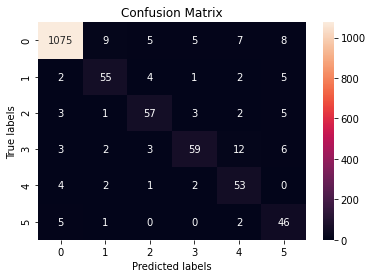

In [202]:
# print(grid_model.best_params_)
model = grid_model.best_estimator_
# model = joblib.load('./models/xgb_raw_data.joblib')
print(classification_report(y_train, model.predict(x_train_new)))
print(classification_report(y_test, model.predict(x_test_new)))
preds = model.predict(x_test_new)

cm = confusion_matrix(preds, y_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

## Weighted samples

C:\Users\Dell\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:14:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4351
           1       1.00      1.00      1.00       294
           2       1.00      1.00      1.00       294
           3       1.00      1.00      1.00       294
           4       1.00      1.00      1.00       286
           5       1.00      1.00      1.00       280

    accuracy                           1.00      5799
   macro avg       1.00      1.00      1.00      5799
weighted avg       1.00      1.00      1.00      5799

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1092
           1       0.80      0.81    

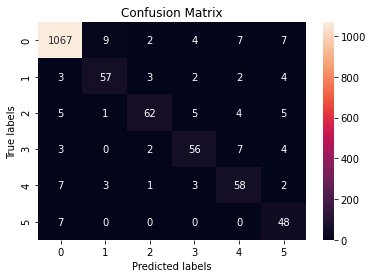

In [54]:
model = XGBClassifier()
model.fit(x_train_new, y_train, sample_weight=sample_weight)
print(classification_report(y_train, model.predict(x_train_new)))
print(classification_report(y_test, model.predict(x_test_new)))
preds = model.predict(x_test_new)

cm = confusion_matrix(preds, y_test)
# cm = np.normalize(cm)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

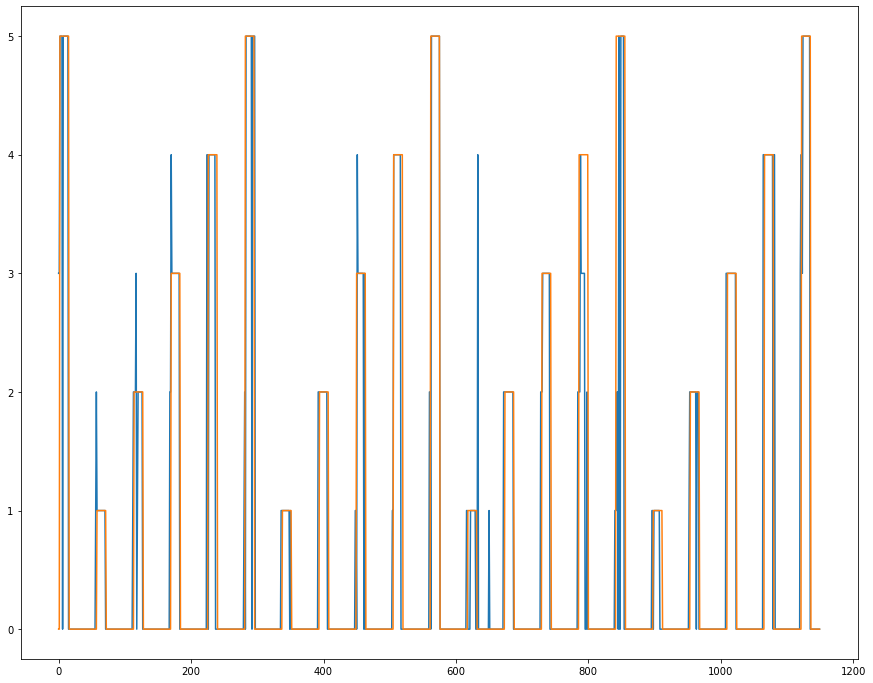

In [63]:
plt.figure(figsize=(15,12))
T1 = 50
T2 = 1200
range_array = range(T2-T1)
plt.plot(range_array, preds[T1:T2])
plt.plot(range_array, y_test[T1-2:T2-2])


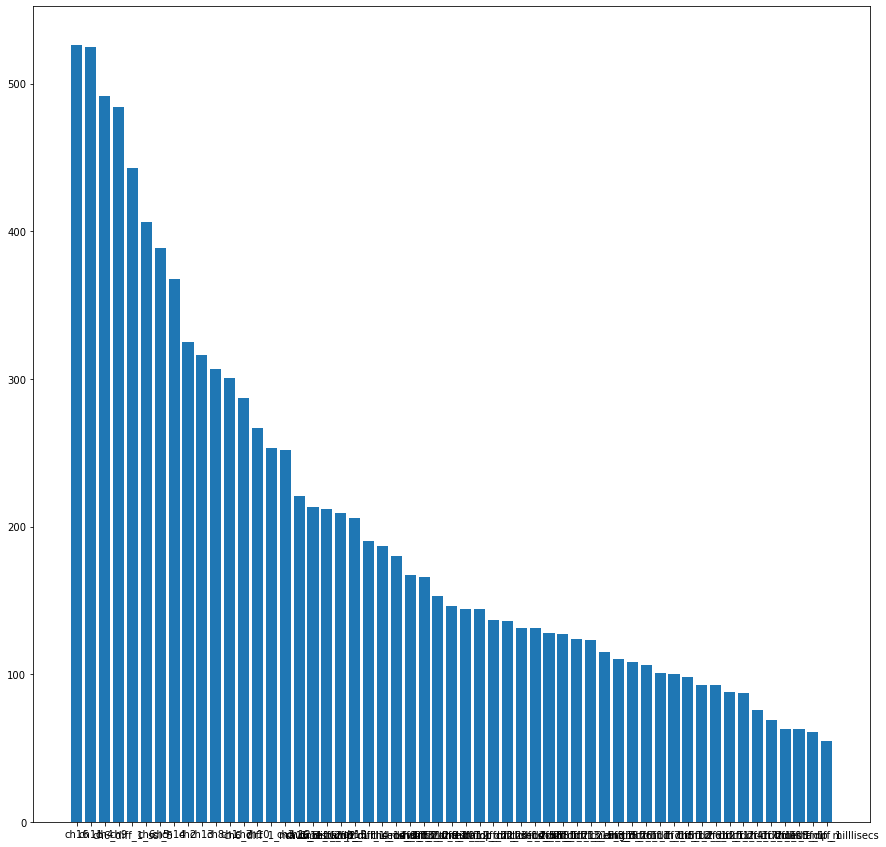

In [45]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())


plt.figure(figsize=(15,15))
plt_data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
# importance_data.plot(kind='barh')
plt.bar(plt_data.index, plt_data['score']);

In [46]:
joblib.dump(model, './models/xgb_weighted_samples.joblib')

FileNotFoundError: [Errno 2] No such file or directory: './models/xgb_weighted_samples.joblib'

In [47]:
1000/72

13.88888888888889

In [48]:
keys

['ch6_diff_1_ssi_5',
 'ch4',
 'ch4_diff_2',
 'ch6',
 'ch14_diff_2',
 'ch12_diff_2',
 'ch1_diff_1',
 'ch3',
 'ch16_diff_1',
 'ch8',
 'timestamp_milllisecs_diff_1',
 'ch5',
 'ch13',
 'ch2',
 'ch9',
 'ch14',
 'ch6_diff_2',
 'ch4_diff_1',
 'ch12_diff_1',
 'ch1_diff_2',
 'ch10_diff_2',
 'ch13_diff_2',
 'ch16',
 'ch9_diff_2',
 'ch6_diff_1_iemg_5',
 'ch11_diff_1',
 'ch16_diff_2',
 'ch6_diff_1',
 'ch15',
 'ch13_diff_1',
 'timestamp_milllisecs_diff_2',
 'ch11_diff_2',
 'ch15_diff_2',
 'ch12',
 'ch6_diff_1_mav1_5',
 'ch6_diff_1_mav2_5',
 'ch3_diff_2',
 'ch7_diff_2',
 'ch1',
 'ch11',
 'timestamp_milllisecs',
 'ch10',
 'ch9_diff_1',
 'ch14_diff_1',
 'ch5_diff_2',
 'ch10_diff_1',
 'ch5_diff_1',
 'ch2_diff_2',
 'ch8_diff_1',
 'ch7',
 'ch7_diff_1',
 'ch15_diff_1',
 'ch3_diff_1',
 'ch8_diff_2',
 'ch2_diff_1']

In [49]:
len(keys)

55